In [7]:
import matplotlib.pyplot as plt
import plt_utils
from pathlib import Path
import numpy as np
import json

In [8]:
def get_config_file(result_paths, group, method):
    return Path("..") / result_paths[group][method] / "config.json"

def get_result_file(result_paths, group, method):
    return Path("..") / result_paths[group][method] / "output.json"

def get_hyperparameters(result_paths):
    config_file = get_config_file(result_paths, 'n_docs=16', 'DRAGON')
    with open(config_file, 'r') as f:
        hyperparameters = json.load(f)
    return {
        'retriever.passages': hyperparameters['retriever']['passages'],
        'evaluator.dataset': hyperparameters['evaluator']['dataset'],
        'generator.model': hyperparameters['generator']['model'],
        'retriever.s_context': hyperparameters['retriever']['s_context'],
        'generator.s_sequence': hyperparameters['generator']['s_sequence'],
        'evaluator.s_prefix': hyperparameters['evaluator']['s_prefix'],
    }

def collect_data(result_paths):
    result_data = {}
    for group in result_paths:
        result_data[group] = {}
        for method in result_paths[group]:
            with open(get_result_file(result_paths, group, method), 'r') as f:
                result_data[group][method] = json.load(f)
    return result_data


with open("result_paths_lm_wikitext2_qwen_seq512.json", 'r') as f:
    result_paths_wikitext2 = json.load(f)
    result_data_wikitext2 = collect_data(result_paths_wikitext2)
    hyperparameters = get_hyperparameters(result_paths_wikitext2)
    print("Hyperparameters for Qwen2.5-1.5B on WikiText2:")
    print(json.dumps(hyperparameters, indent=2))

with open("result_paths_lm_wikitext103_opt.json", 'r') as f:
    result_paths_wikitext103 = json.load(f)
    result_data_wikitext103 = collect_data(result_paths_wikitext103)
    hyperparameters = get_hyperparameters(result_paths_wikitext103)
    print("Hyperparameters for OPT-1.3B on WikiText103:")
    print(json.dumps(hyperparameters, indent=2))


Hyperparameters for Qwen2.5-1.5B on WikiText2:
{
  "retriever.passages": "Salesforce/wikitext,wikitext-2-raw-v1",
  "evaluator.dataset": "Salesforce/wikitext,wikitext-2-raw-v1",
  "generator.model": "Qwen/Qwen2.5-1.5B",
  "retriever.s_context": 256,
  "generator.s_sequence": 512,
  "evaluator.s_prefix": 64
}
Hyperparameters for OPT-1.3B on WikiText103:
{
  "retriever.passages": "Salesforce/wikitext,wikitext-103-raw-v1",
  "evaluator.dataset": "Salesforce/wikitext,wikitext-103-raw-v1",
  "generator.model": "facebook/opt-1.3b",
  "retriever.s_context": 256,
  "generator.s_sequence": 1024,
  "evaluator.s_prefix": 128
}


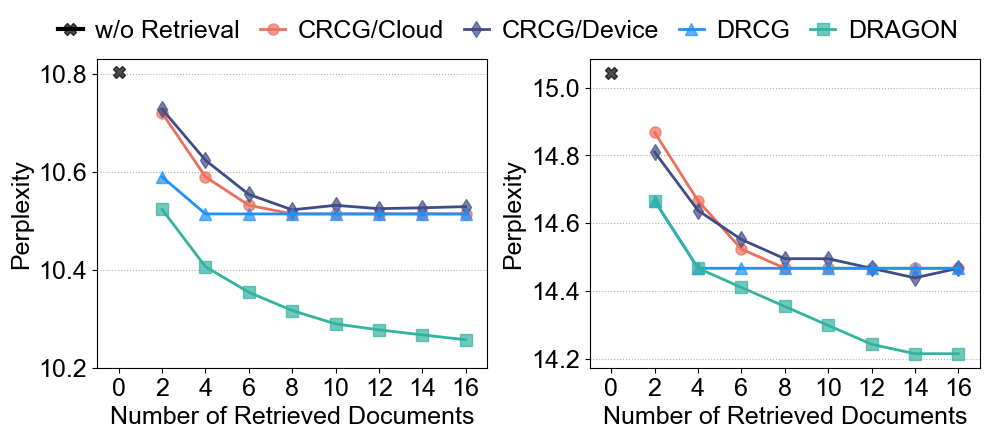

In [27]:
def hex2rgb(hex_color: str):
    hex_color = hex_color.lstrip('#')
    rgb_color = list(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
    return rgb_color

metric = 'perplexity'
methods = ["CRCG/Cloud", "CRCG/Device", "DRCG", "DRAGON"]
color_no_retrieval = '#000000'
colors = ['#EC6F5C', '#414C87', '#1F90FF', '#33B39F']
marker = ['o', 'd', '^', 's']
font = plt_utils.Font("arial", size=18)
n_docs_list = list(range(2, 17, 2))
marker_alpha = 0.7
plt.figure(figsize=(10, 4), dpi=100)
for i, result_data in enumerate([result_data_wikitext2, result_data_wikitext103]):
    n_docs_list_ = [n_docs for n_docs in n_docs_list if f'n_docs={n_docs}' in result_data]
    data_list = []
    plt.subplot(1, 2, i + 1)
    data = [result_data['n_docs=0']['W/O Retrieval'][metric]]
    data_list += data
    plt.plot(
        data, label='w/o Retrieval', color=color_no_retrieval, marker='X',
        linewidth=3, markersize=8, markerfacecolor=hex2rgb(color_no_retrieval) + [marker_alpha]
    )
    for j, method in enumerate(methods):
        data = [result_data[f'{n_docs=}'][method][metric] for n_docs in n_docs_list_]
        data_list += data
        plt.plot(
            n_docs_list_, data, label=method, marker=marker[j], 
            color=colors[j % len(colors)], linewidth=2, markersize=8,
            markerfacecolor=hex2rgb(colors[j % len(colors)]) + [marker_alpha]
        )
    min_data, max_data = np.min(data_list), np.max(data_list)
    min_data, max_data = int(min_data * 10) / 10, int(max_data * 10 + 1) / 10
    plt.xlim(-1, n_docs_list_[-1] + 1)
    plt.xticks(fontproperties=font)
    plt.yticks(fontproperties=font)
    plt.yticks(np.arange(min_data, max_data + 0.05, 0.2))
    plt.xlabel('Number of Retrieved Documents', fontproperties=font)
    plt.ylabel("Perplexity", fontproperties=font)
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
plt.legend(
    prop=font, loc='upper right', bbox_to_anchor=(1, 1.2),
    ncol=5, labelspacing=0.2, columnspacing=0.8, 
    frameon=False, handlelength=1, handletextpad=0.5
)
plt.savefig('perplexity.pdf', bbox_inches='tight')
plt.show()